### Импорт необходимых библиотек

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
%matplotlib inline

Импорт файлов

In [2]:
df_ndvi = pd.read_csv("train/NDVI.csv", sep=",", encoding="windows-1251")
df_nir = pd.read_csv("train/B8A.csv", sep=',', encoding="windows-1251")
df_swir = pd.read_csv("train/B12.csv", sep=',', encoding="windows-1251")
df_green = pd.read_csv("train/B03.csv", sep=',', encoding="windows-1251")
df_red = pd.read_csv("train/B04.csv", sep=',', encoding="windows-1251")
df_blue = pd.read_csv("train/B02.csv", sep=',', encoding="windows-1251")

Заполнение по среднему в группах

In [3]:
df_nir = df_nir.groupby('culture').apply(lambda x: x.fillna(x.mean())).reset_index().drop(columns=['level_1', 'index'])
df_swir = df_swir.groupby('culture').apply(lambda x: x.fillna(x.mean())).reset_index().drop(columns=['level_1', 'index'])
df_ndvi = df_ndvi.groupby('culture').apply(lambda x: x.fillna(x.mean())).reset_index().drop(columns=['level_1', 'index'])
df_green = df_green.groupby('culture').apply(lambda x: x.fillna(x.mean())).reset_index().drop(columns=['level_1', 'index'])
df_red = df_red.groupby('culture').apply(lambda x: x.fillna(x.mean())).reset_index().drop(columns=['level_1', 'index'])
df_blue = df_blue.groupby('culture').apply(lambda x: x.fillna(x.mean())).reset_index().drop(columns=['level_1', 'index'])

Обработка данных

In [4]:
df_ndvi.loc[df_ndvi['culture'] == 'залежь', '226'] += 0.02
df_ndvi.loc[df_ndvi['culture'] == 'зерновые', '226'] += 0.08
df_ndvi.loc[df_ndvi['culture'] == 'кукуруза', '226'] += 0.18
df_ndvi.loc[df_ndvi['culture'] == 'многолетние травы', '226'] += 0.04
df_ndvi.loc[df_ndvi['culture'] == 'овощи', '226'] += 0.15
df_ndvi.loc[df_ndvi['culture'] == 'соя', '226'] += 0.15

Фичи

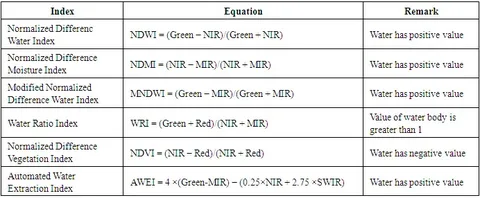

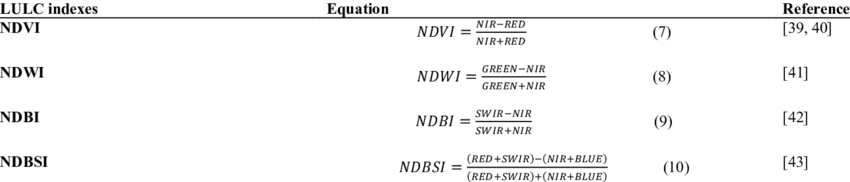

In [5]:
df_features = df_ndvi.copy()
xx = ['121', '128', '135', '142', '149', '156', '163', '170', '177', '184', '191', '198', '205', '212', '219', '226', '233', '240', '247', '254', '261', '268', '275', '282', '289', '296']
for day in xx:
    df_features[f"{day}_NDWI"] = (df_nir[day] - df_swir[day]) / (df_nir[day] + df_swir[day])
    df_features[f"{day}_NEW"] = df_ndvi[day] * df_features[f"{day}_NDWI"]
    df_features[f'{day}_NDWI1'] = (df_green[day] - df_nir[day]) / (df_green[day] + df_nir[day])
    df_features[f'{day}_NDVI'] = (df_nir[day] - df_red[day]) / (df_red[day] + df_nir[day])
    df_features[f'{day}_NDBI'] = (df_swir[day] - df_nir[day])/ (df_swir[day] + df_nir[day])

C:\Users\ihydh\AppData\Local\Temp\ipykernel_18128\1626392484.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f'{day}_NDVI'] = (df_nir[day] - df_red[day]) / (df_red[day] + df_nir[day])
C:\Users\ihydh\AppData\Local\Temp\ipykernel_18128\1626392484.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f'{day}_NDBI'] = (df_swir[day] - df_nir[day])/ (df_swir[day] + df_nir[day])
C:\Users\ihydh\AppData\Local\Temp\ipykernel_18128\1626392484.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usual

Модель


In [6]:
encoder = OneHotEncoder()
x = df_features.drop(columns=["culture"])
standardizer = StandardScaler()
x = standardizer.fit_transform(x)

y = pd.DataFrame(encoder.fit_transform(df_features[['culture']]).toarray(), columns=encoder.get_feature_names_out(['culture']))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [20]:
import keras
from keras.layers import Input, Dense, Normalization, Dropout
from keras.models import Model

inputs = Input(shape=(156,))
output_1 = Dense(128, activation='relu')(inputs)
output_2 = Normalization()(output_1)
output_3 = Dense(512, activation='relu')(output_2)
output_4 = Dropout(0.5)(output_3)
output_5 = Dense(256, activation='relu')(output_4)
output_6 = Dropout(0.5)(output_5)
output_7 = Dense(32, activation='relu')(output_6)
output_8 = Dense(6)(output_7)
predictions = Dense(6, activation='softmax')(output_8)

model = Model(inputs=inputs, outputs=predictions)

model.compile(keras.optimizers.Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['f1_score'])

Epoch 1/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - f1_score: 0.6579 - loss: 0.9245 - val_f1_score: 0.9391 - val_loss: 0.1924
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - f1_score: 0.9222 - loss: 0.2246 - val_f1_score: 0.9589 - val_loss: 0.1231
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - f1_score: 0.9545 - loss: 0.1395 - val_f1_score: 0.9748 - val_loss: 0.0954
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - f1_score: 0.9676 - loss: 0.1029 - val_f1_score: 0.9754 - val_loss: 0.0810
Epoch 5/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.9774 - loss: 0.0695 - val_f1_score: 0.9780 - val_loss: 0.0796
Epoch 6/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - f1_score: 0.9789 - loss: 0.0677 - val_f1_score: 0.9787 - val_loss: 0.0754
Epoch 7/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - f1_score: 0.9843 - loss: 0.0486 - val_f1_score: 0.9814 - val_loss: 0.0702
Epoch 8/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - f1_score: 0.9839 - loss: 0.0527 - val_f1_s

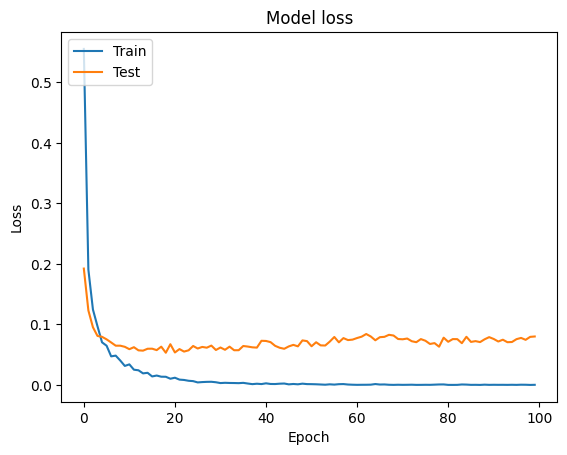

In [21]:
import matplotlib.pyplot as plt 
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100)
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Сохранение модели

In [11]:
with open("model.pkl", 'wb') as file:
    pickle.dump(model, file)

Прогноз

In [12]:
df_ndvi_test = pd.read_csv("test/NDVI.csv", sep=";", encoding="windows-1251")
df_nir_test = pd.read_csv("test/B8A.csv", sep=';', encoding="windows-1251")
df_swir_test = pd.read_csv("test/B12.csv", sep=';', encoding="windows-1251")
df_green_test = pd.read_csv("test/B03.csv", sep=';', encoding="windows-1251")
df_red_test = pd.read_csv("test/B04.csv", sep=';', encoding="windows-1251")
df_blue_test = pd.read_csv("test/B02.csv", sep=';', encoding="windows-1251")

df_features_test = df_ndvi_test.copy().drop(columns=['index'])
for day in xx:
    df_features_test[f"{day}_NDWI"] = (df_nir_test[day] - df_swir_test[day]) / (df_nir_test[day] + df_swir_test[day])
    df_features_test[f"{day}_NEW"] = df_ndvi_test[day] * df_features_test[f"{day}_NDWI"]
    df_features_test[f'{day}_NDWI1'] = (df_green_test[day] - df_nir_test[day]) / (df_green_test[day] + df_nir_test[day])
    df_features_test[f'{day}_NDVI'] = (df_nir_test[day] - df_red_test[day]) / (df_red_test[day] + df_nir_test[day])
    df_features_test[f'{day}_NDBI'] = (df_swir_test[day] - df_nir_test[day])/ (df_swir_test[day] + df_nir_test[day])

C:\Users\ihydh\AppData\Local\Temp\ipykernel_18128\2199674963.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features_test[f'{day}_NDBI'] = (df_swir_test[day] - df_nir_test[day])/ (df_swir_test[day] + df_nir_test[day])
C:\Users\ihydh\AppData\Local\Temp\ipykernel_18128\2199674963.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features_test[f"{day}_NDWI"] = (df_nir_test[day] - df_swir_test[day]) / (df_nir_test[day] + df_swir_test[day])
C:\Users\ihydh\AppData\Local\Temp\ipykernel_18128\2199674963.py:11: Performance

In [13]:
x = df_features_test
standardizer = StandardScaler()
x = standardizer.fit_transform(x)

ans_test = model.predict(x)
pred_ans_test = np.zeros_like(ans_test).astype("int32")
pred_ans_test[np.arange(len(ans_test)), ans_test.argmax(1)] = 1

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Запись

In [14]:
with open("predicted.csv", encoding="windows-1251", mode="w") as file:
    file.write("culture\n")
    for row in encoder.inverse_transform(pred_ans_test):
        file.write(f"{row[0]}\n")

Доп графики

['залежь', 'зерновые', 'кукуруза', 'многолетние травы', 'овощи', 'соя']


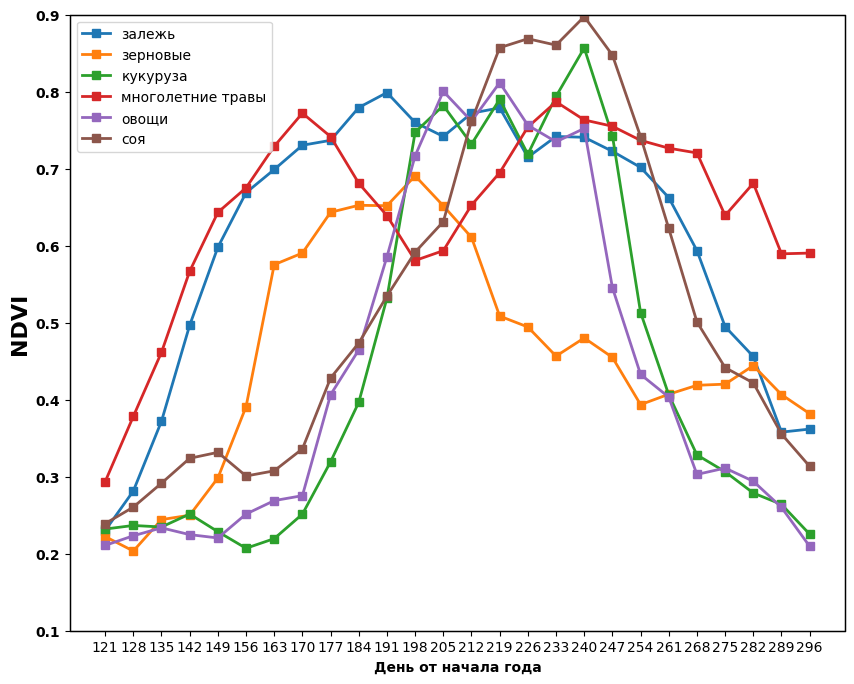

In [15]:
cul = list(df_ndvi['culture'].unique().tolist())
print(cul)
fig, ax = plt.subplots(figsize=(10,8))

plt.yticks(fontsize=10)

ax.set_xlabel('День от начала года',fontsize = 10,fontweight="bold")
ax.set_ylabel('NDVI',fontsize = 16,fontweight="bold")
ax.patch.set_edgecolor('black')

ax.patch.set_linewidth(1)
plt.ylim([0.1, 0.9])


xx = ['121', '128', '135', '142', '149', '156', '163', '170', '177', '184', '191', '198', '205', '212', '219', '226', '233', '240', '247', '254', '261', '268', '275', '282', '289', '296']
colors = plt.cm.coolwarm(np.array(len(cul)))
for i in range(len(cul)):
    p = df_ndvi.loc[(df_ndvi['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()

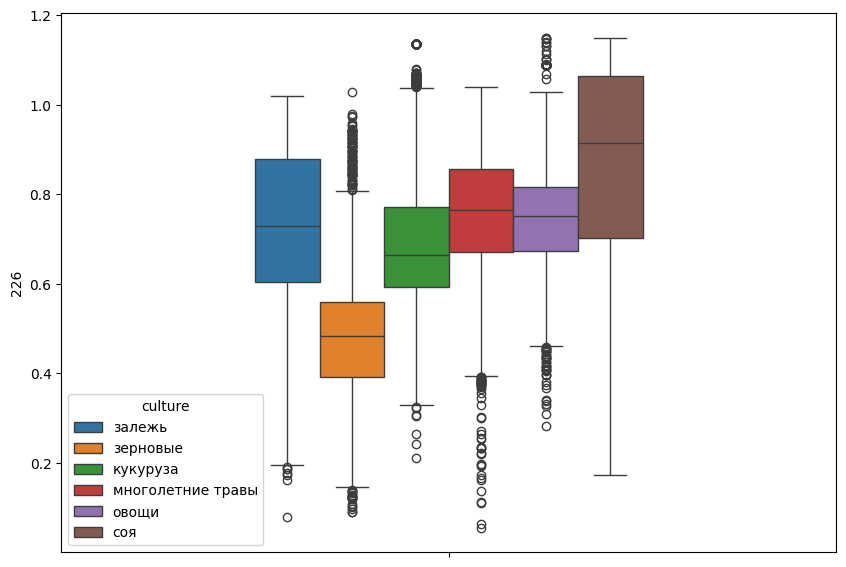

In [16]:
fig = plt.figure(figsize=(10,7))
sns.boxplot(data=df_ndvi, y='226', width=.5, hue='culture')
plt.show()

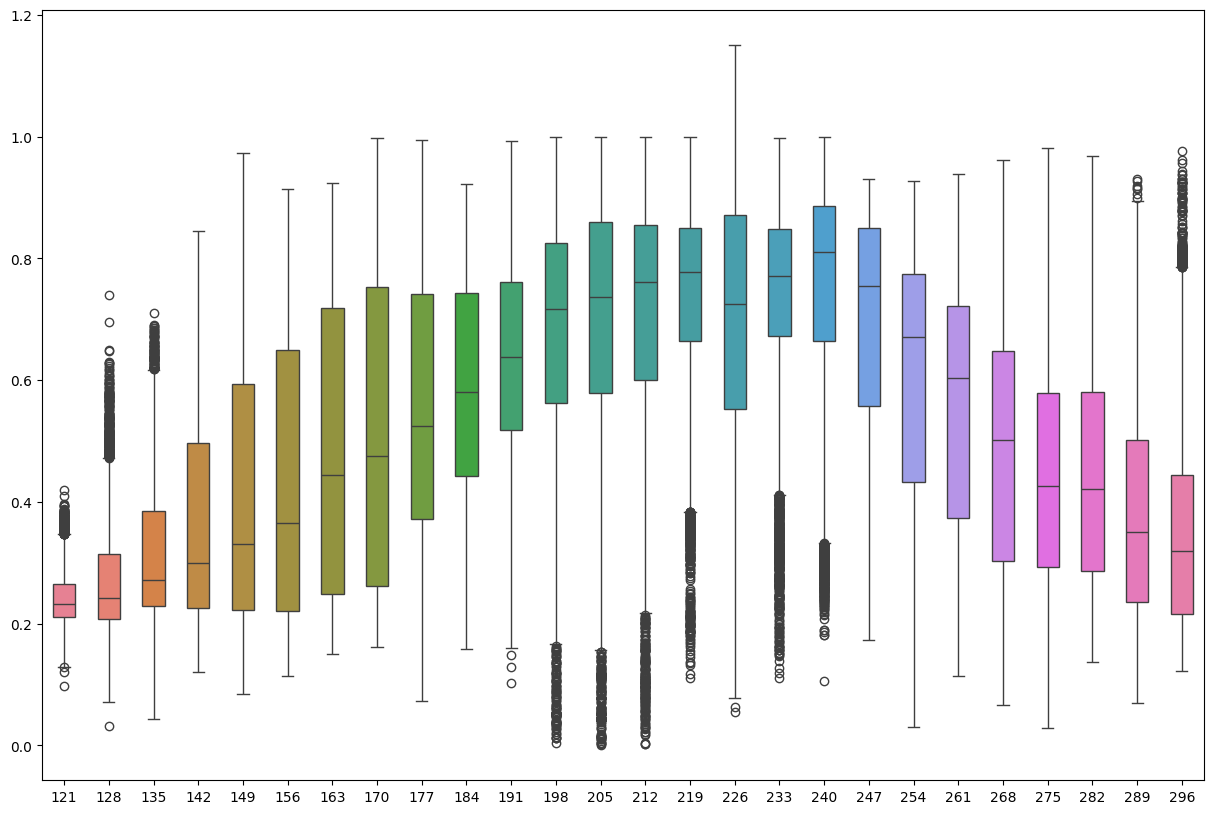

In [17]:
fig = plt.figure(figsize=(15,10))
sns.boxplot(data=df_ndvi, width=.5)
plt.show()